In [97]:
import tensorflow;
import pandas;
from sklearn.model_selection import train_test_split;
from tensorflow import keras;
from tensorflow.keras.models import Sequential;
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt;
from tensorflow.keras.utils import plot_model;
import requests;
import time;

from imblearn.over_sampling import SMOTE;

In [98]:
tensorflow.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Data Import

In [99]:
# Loading data from pre-cleaned csv file
current_folder = "/mnt/d/Code/College/Machine Learning/Team Assignment/Default Credit Scoring/";
# current_folder = "";
dataframe = pandas.read_csv(current_folder + "credit_card_clients.csv");

dataframe = dataframe.drop(columns = ["ID"]);

dataframe.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,LABEL
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## Feature Correlation

In this section I set the treshold with 0.2. Any feature below 0.2 will be discarded.

In [100]:
# Correlation Heatmap
correlation = dataframe.corr();

TRESHOLD = 0;
print("Relationship : Correlation Score");

columns_to_be_dropped = [];
for i in correlation.columns:
    correlation_score = correlation[i]["LABEL"];
    print(i, "-> LABEL : ", correlation_score);

    # When data are oversampled, Education seems more uncorrelated through the LABEL. Skipping drop the Education.
    if(i == "EDUCATION"):
        continue;

    if(correlation_score < TRESHOLD):
        columns_to_be_dropped.append(i);
        print("Dropping ", i);

dataframe = dataframe.drop(columns=columns_to_be_dropped);

Relationship : Correlation Score
LIMIT_BAL -> LABEL :  -0.1535198763935072
Dropping  LIMIT_BAL
SEX -> LABEL :  -0.03996057770544172
Dropping  SEX
EDUCATION -> LABEL :  0.028006077656250204
MARRIAGE -> LABEL :  -0.024339215683404438
Dropping  MARRIAGE
AGE -> LABEL :  0.013889834301962887
PAY_0 -> LABEL :  0.32479372847862237
PAY_2 -> LABEL :  0.2635512016721678
PAY_3 -> LABEL :  0.23525251372491712
PAY_4 -> LABEL :  0.21661363684242388
PAY_5 -> LABEL :  0.2041489138761645
PAY_6 -> LABEL :  0.18686636165354611
BILL_AMT1 -> LABEL :  -0.019644197143221562
Dropping  BILL_AMT1
BILL_AMT2 -> LABEL :  -0.014193218088215756
Dropping  BILL_AMT2
BILL_AMT3 -> LABEL :  -0.014075518043214726
Dropping  BILL_AMT3
BILL_AMT4 -> LABEL :  -0.010156495880289674
Dropping  BILL_AMT4
BILL_AMT5 -> LABEL :  -0.006760463841014779
Dropping  BILL_AMT5
BILL_AMT6 -> LABEL :  -0.005372314914815558
Dropping  BILL_AMT6
PAY_AMT1 -> LABEL :  -0.07292948777785163
Dropping  PAY_AMT1
PAY_AMT2 -> LABEL :  -0.05857870658290157

## Data Pre-Processing
Checkout the `main.ipynb` since I just copy-pasting the whole thing from it.

In [101]:
# Some education data contains 0, 5, and 6. I eliminating "em.

invalid_education_data = [];
for idx, e in enumerate(dataframe['EDUCATION']):
    if(e > 4 or e < 1):
        invalid_education_data.append(idx);

dataframe = dataframe.drop(invalid_education_data);

# Make one hot encoding for Educuation and PAY_0 to 6 since the data is an ordinal data
hot_encoded_education = pandas.get_dummies(dataframe['EDUCATION'], prefix = "education");
hot_encoded_pay_0 = pandas.get_dummies(dataframe['PAY_0'], prefix = "pay_0");
hot_encoded_pay_2 = pandas.get_dummies(dataframe['PAY_2'], prefix = "pay_2");
hot_encoded_pay_3 = pandas.get_dummies(dataframe['PAY_3'], prefix = "pay_3");
hot_encoded_pay_4 = pandas.get_dummies(dataframe['PAY_4'], prefix = "pay_4");
hot_encoded_pay_5 = pandas.get_dummies(dataframe['PAY_5'], prefix = "pay_5");
hot_encoded_pay_6 = pandas.get_dummies(dataframe['PAY_6'], prefix = "pay_6");

# Merge the hot_encoded with the main dataframe
for i in [hot_encoded_education, hot_encoded_pay_0, hot_encoded_pay_2, hot_encoded_pay_3, hot_encoded_pay_4, hot_encoded_pay_5, hot_encoded_pay_6]:
    dataframe = pandas.concat([dataframe, i], axis = 1);

print("Data after cleaning: ", dataframe.shape);
print(dataframe.columns.tolist());

Data after cleaning:  (29655, 77)
['EDUCATION', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'LABEL', 'education_1', 'education_2', 'education_3', 'education_4', 'pay_0_-2', 'pay_0_-1', 'pay_0_0', 'pay_0_1', 'pay_0_2', 'pay_0_3', 'pay_0_4', 'pay_0_5', 'pay_0_6', 'pay_0_7', 'pay_0_8', 'pay_2_-2', 'pay_2_-1', 'pay_2_0', 'pay_2_1', 'pay_2_2', 'pay_2_3', 'pay_2_4', 'pay_2_5', 'pay_2_6', 'pay_2_7', 'pay_2_8', 'pay_3_-2', 'pay_3_-1', 'pay_3_0', 'pay_3_1', 'pay_3_2', 'pay_3_3', 'pay_3_4', 'pay_3_5', 'pay_3_6', 'pay_3_7', 'pay_3_8', 'pay_4_-2', 'pay_4_-1', 'pay_4_0', 'pay_4_1', 'pay_4_2', 'pay_4_3', 'pay_4_4', 'pay_4_5', 'pay_4_6', 'pay_4_7', 'pay_4_8', 'pay_5_-2', 'pay_5_-1', 'pay_5_0', 'pay_5_2', 'pay_5_3', 'pay_5_4', 'pay_5_5', 'pay_5_6', 'pay_5_7', 'pay_5_8', 'pay_6_-2', 'pay_6_-1', 'pay_6_0', 'pay_6_2', 'pay_6_3', 'pay_6_4', 'pay_6_5', 'pay_6_6', 'pay_6_7', 'pay_6_8']


In [102]:
# Define label data
label = dataframe['LABEL'];

# Drop ID, SEX, EDUCATION, MARRIAGE, and LABEL from dataframe for features
features = dataframe.drop(columns=["EDUCATION", 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', "LABEL"]);

# Typecasting all values within to int64 because ANN need to be standardized

for i in dataframe.columns:
    dataframe[i] = dataframe[i].astype(int);

# Split the data into training, validation, and testing sets
feature_train, feature_test, label_train, label_test = train_test_split(features, label, train_size = 0.7, test_size = 0.3, random_state = 42);
feature_validation, feature_test, label_validation, label_test = train_test_split(feature_test, label_test, test_size=0.5, random_state = 42);

# Scale the features
scaler = StandardScaler();
feature_train_scaled = scaler.fit_transform(feature_train);
feature_validation_scaled = scaler.fit_transform(feature_validation);
feature_test_scaled = scaler.transform(feature_test);

In [103]:
def telegram_reporter(message):
    message = "["+ time.strftime("%Y-%m-%d %H:%M:%S") +"] " + message
    requests.request(method="POST", url="https://api.telegram.org/bot6307342709:AAEehfQrvZzQhk2hFlOW7C1JnE2hRQYLEgE/sendMessage?chat_id=-1001525528850&text=" + message, headers={}, data={});

## Fine Tunning

This code based on Tensorflow Artifical Neural Network.

(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 256)
(None, 128)
(None, 128)
(None, 128)
(None, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 64)
(None, 32)
(None, 32)
(None, 32)
(None, 32)
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_85 (Dense)            (None, 256)               17920     
                                                                 
 activation_27 (Activation)  (None, 256)               0         
                                                                 
 batch_normalization_69 (Ba  (None, 256)               1024      
 tchNormalization)                                               
                                                                 
 dropout_59 (Dropout)        (None, 256)               0         
                                                     

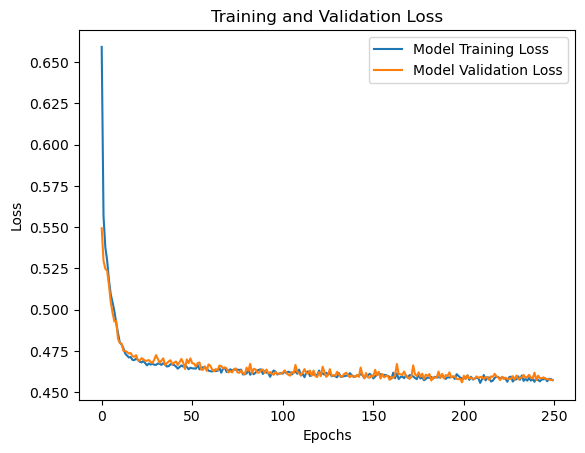

140/140 [==============================] - 1s 5ms/step - loss: 0.4564 - accuracy: 0.8170
Loss:  0.456437885761261  Accuracy:  0.8170375227928162


In [104]:
class ANNModel:

    # Hyperparameters
    def input_layer(self):
        return keras.layers.InputLayer(input_shape = (69,)); # 11 is total features dimension

    def hidden_layer(self):
        return [
            keras.layers.Dense(256, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("sigmoid"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
            
            keras.layers.Dense(256, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("sigmoid"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
            
            keras.layers.Dense(128, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
        ];

    def shallow_hidden_layer(self):
        return [
            keras.layers.Dense(64, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("sigmoid"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(64, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("sigmoid"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
            keras.layers.Dense(32, kernel_initializer = "glorot_uniform", kernel_regularizer = tensorflow.keras.regularizers.l2(1e-4)),
            keras.layers.Activation("sigmoid"),
            keras.layers.BatchNormalization(),
            keras.layers.Dropout(0.5),
        ];

    def output_layer(self):
        return keras.layers.Dense(1, kernel_initializer = "glorot_uniform", activation = "sigmoid"); # Since output is only 1 label.

    def optimizer(self):
        return keras.optimizers.Adam(learning_rate = 1e-3);

    def loss(self):
        return "binary_crossentropy";

    def metrics(self):
        return "accuracy";

    def epoch(self):
        return 1;

        
    # Callbacks
    # Backup Model to h5 file
    def _callback_model_backup(self):
        checkpoint_path = current_folder + "/cua/" + "model_checkpoint.h5";

        return tensorflow.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_path,
            save_weights_only=True,
            save_freq='epoch'
        );

    # Early stopping after loss are not improved for some epochs
    def _callback_early_stopping(self):
        early_stopping_tolerance = 50;

        return tensorflow.keras.callbacks.EarlyStopping(
            monitor = "val_loss",
            patience = early_stopping_tolerance,
            restore_best_weights = True
        );

    # Fitting
    def fit(self):

        # Construct the model 
        model = Sequential();
        model.add(self.input_layer());

        for i in [self.hidden_layer(), self.shallow_hidden_layer()]:
            for j in i:
                model.add(j);
                print(model.output_shape)

        model.add(self.output_layer());

        # Draw the model architecture
        plot_model(model, to_file=(current_folder + "/cua/" + "model_architecture.png"), show_shapes=True)
        model.summary()

        # Compile the model pipeline
        model.compile(loss = self.loss(), optimizer = self.optimizer(), metrics=[self.metrics()]);

        telegram_reporter("Starting training model with code [202401200128] with total epoch of " + str(self.epoch()));

        # Fitting
        model_plot = model.fit(
            feature_train_scaled, 
            label_train, 
            epochs = self.epoch(), 
            validation_data = (feature_validation_scaled, label_validation), 
            callbacks = [self._callback_model_backup(), self._callback_early_stopping()] 
        );

        plt.plot(model_plot.history["loss"], label = "Model Training Loss");
        plt.plot(model_plot.history["val_loss"], label = "Model Validation Loss");
        plt.title("Training and Validation Loss");
        plt.xlabel("Epochs");
        plt.ylabel("Loss");
        plt.legend();
        plt.show();

        return model;

dojo = ANNModel();
model = dojo.fit();

loss, accuracy = model.evaluate(feature_test_scaled, label_test);
print("Loss: ", loss, " Accuracy: ", accuracy);

telegram_reporter("Finished training with Loss: " + str(loss) + " Accuracy: " + str(accuracy));